<a href="https://colab.research.google.com/github/TeDand/2048/blob/master/examples/gemini_nav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q llmx
!pip install -q langchain
!pip install -q google-generativeai langchain-google-genai
!pip install -q sentence_transformers
!pip install -q faiss-gpu
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
import random
from langchain.prompts import (
    PromptTemplate,
    FewShotPromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
)
from langchain_core.messages import SystemMessage
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage,
)
from langchain.prompts.example_selector.ngram_overlap import (
    NGramOverlapExampleSelector
)
from langchain.prompts.example_selector import (
    MaxMarginalRelevanceExampleSelector,
    SemanticSimilarityExampleSelector,
    LengthBasedExampleSelector,
)
from langchain.agents import (
    load_tools,
    initialize_agent,
    AgentType,
)
from langchain.pydantic_v1 import (
    BaseModel,
    Field,
)
from langchain.tools import (
    BaseTool,
    StructuredTool,
    tool,
)
from langchain_core.example_selectors.base import BaseExampleSelector
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain.chains import LLMChain
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
import textwrap
from IPython.display import Markdown


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.5/807.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
model = ChatGoogleGenerativeAI(model="gemini-pro",
                               google_api_key=GOOGLE_API_KEY,
                               convert_system_message_to_human=True)

Roadmap:

- Generate reference path and check its length and if it hits obstacles (need to generate obstacles too)
- Visualise
- Generate motor movements (bicycle model)
- Can add lanes
- Then have obstacles moving too

# Class Constructors

In [ ]:
def tuple_to_string(tuple_object):
    # Check if the input is a tuple
    if not isinstance(tuple_object, tuple):
        raise TypeError("Input must be a tuple.")

    # Join the elements of the tuple with commas
    string_representation = ', '.join(map(str, tuple_object))

    return "(" + string_representation + ")"

class Vehicle:
  def __init__(self, center=(0, 0), yaw=0, width=3, height=3):
    self.__center_x = center[0]
    self.__center_y = center[1]
    self.__yaw = yaw
    self.__width = width
    self.__height = height

  def randomize_vehicle(self, x_range, y_range, yaw_range, width_range,
                        height_range):
    self.__center_x = random.uniform(*x_range)
    self.__center_y = random.uniform(*y_range)
    self.__yaw = random.uniform(*yaw_range)
    self.__width = random.uniform(*width_range)
    self.__height = random.uniform(*height_range)

  def get_center(self):
    return (self.__center_x, self.__center_y)

  def get_yaw(self):
    return self.__yaw

  def get_width(self):
    return self.__width

  def get_height(self):
    return self.__height

  def __check_overlap(self, other_vehicle):
    # Expand the bounding box slightly to ensure a gap between vehicles
    expansion = 0.1
    # (center_x, center_y, yaw, width, height)
    v1_x1, v1_y1 = (self.__center_x - self.__width/2 - expansion,
                    self.__center_y - self.__height/2 - expansion)
    v1_x2, v1_y2 = (self.__center_x + self.__width/2 + expansion,
                    self.__center_y + self.__height/2 + expansion)
    v2_x1, v2_y1 = (other_vehicle.get_center()[0] - other_vehicle.get_width()/2
                    - expansion, other_vehicle.get_center()[1]
                    - other_vehicle.get_height()/2 - expansion)
    v2_x2, v2_y2 = (other_vehicle.get_center()[0] + other_vehicle.get_width()/2
                    + expansion, other_vehicle.get_center()[1]
                    + other_vehicle.get_height()/2 + expansion)

    # Check if there's any overlap
    overlap_x = v1_x1 < v2_x2 and v1_x2 > v2_x1
    overlap_y = v1_y1 < v2_y2 and v1_y2 > v2_y1
    return overlap_x and overlap_y

  def overlaps(self, other_vehicles):
    for other_vehicle in other_vehicles:
      if self.__check_overlap(other_vehicle):
        return True

    return False

class Robot:
  def __init__(self, pos_center=(0, 0), dest_center=(0, 0), radius=4,
               orientation=0):
    self.__center_x = pos_center[0]
    self.__center_y = pos_center[1]
    self.__radius = radius
    self.__dest_x = dest_center[0]
    self.__dest_y = dest_center[1]
    self.__orientation = orientation

  def get_position(self):
    return (self.__center_x, self.__center_y)

  def get_destination(self):
    return (self.__dest_x, self.__dest_y)

  def get_orientation(self):
    return self.__orientation

  def copy(self):
    return Robot((self.__center_x, self.__center_y),
     (self.__dest_x, self.__dest_y), self.__radius, self.__orientation)

  def move_forward(self, dist):
    orientation_radians = np.radians(self.__orientation)

    new_x = self.__center_x + dist * math.cos(orientation_radians)
    new_y = self.__center_y + dist * math.sin(orientation_radians)

    self.__center_x = new_x
    self.__center_y = new_y

  def rotate(self, deg):
    self.__orientation += deg

  def is_position_safe(self, position, vehicles):
    for vehicle in vehicles:
      expanded_width = vehicle.get_width() / 2 + self.__radius
      expanded_height = vehicle.get_height() / 2 + self.__radius
      if (abs(position[0] - vehicle.get_center()[0]) < expanded_width
          and abs(position[1] - vehicle.get_center()[1]) < expanded_height):
        return False
    return True

  def __generate_safe_position(self, x_range, y_range, vehicles):
    while True:
      position = (random.uniform(*x_range), random.uniform(*y_range))
      if self.is_position_safe(position, vehicles):
          return position

  def randomize_pos_dest(self, x_range, y_range, vehicles):
    self.__center_x, self.__center_y = self.__generate_safe_position(x_range,
                                                                     y_range,
                                                                     vehicles)
    self.__dest_x, self.__dest_y = self.__generate_safe_position(x_range,
                                                                 y_range,
                                                                 vehicles)
    self.__orientation = random.uniform(0, 360)

class Scenario:
  def __init__(self, vehicle_range=(20, 50), x_range=(-100, 100),
               y_range=(-100, 100), yaw_range=(0, 360), width_range=(1, 5),
               height_range=(1, 5)):
    self.__x_range = x_range
    self.__y_range = y_range
    # Generate vehicles ensuring no overlap
    vehicles = []
    # Maximum attempts to place each vehicle to avoid infinite loops
    attempts_per_vehicle = 100

    # Randomly decide the number of vehicles
    num_vehicles = random.randint(*vehicle_range)

    for _ in range(num_vehicles):
        for _ in range(attempts_per_vehicle):
            new_vehicle = Vehicle()
            new_vehicle.randomize_vehicle(self.__x_range, y_range, yaw_range,
                                          width_range, height_range)
            if not new_vehicle.overlaps(vehicles):
                vehicles.append(new_vehicle)
                break

    self.__vehicles = vehicles

    self.__robot = Robot()
    self.__robot.randomize_pos_dest(self.__x_range, self.__y_range, vehicles)

    self.__path = None
    # Example usage
    # uncomment the path generation for your life
    # self.__path = generate_rrt_star_path(original_position,
    #                                      destination_position, vehicles,
    #                                      robot_radius)

  def get_vehicles(self):
    return self.__vehicles

  def get_robot(self):
    return self.__robot

  def get_map_range(self):
    return self.__x_range, self.__y_range

  def get_path(self):
    return self.__path

  def describe(self):
    vehicles_string = ""

    for vehicle in self.__vehicles:
      vehicles_string += "- {0}, {1}, {2} \n ".format(
          tuple_to_string(vehicle.get_center()),
          vehicle.get_yaw(),
          tuple_to_string((vehicle.get_width(), vehicle.get_height())))

    return (str(self.__x_range), str(self.__y_range), vehicles_string,
            tuple_to_string(self.__robot.get_position()),
            str(self.__robot.get_orientation()),
            tuple_to_string(self.__robot.get_destination()))

  def visualise(self, figsize=(12, 12)):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    x_range, y_range = self.get_map_range()
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)

    for vehicle in self.get_vehicles():
        # Create a rectangle with the vehicle's dimensions
        rect = patches.Rectangle((-vehicle.get_width() / 2, \
                                  -vehicle.get_height() / 2), \
                                 vehicle.get_width(), vehicle.get_height(), \
                                 linewidth=1, edgecolor='r', facecolor='none')

        # Rotate and translate the rectangle according to the vehicle's
        # yaw and center position
        t = (Affine2D().rotate_deg(-vehicle.get_yaw()) +
             Affine2D().translate(vehicle.get_center()[0],
                                  vehicle.get_center()[1]) + ax.transData)
        rect.set_transform(t)

        # Add the rectangle to the plot
        ax.add_patch(rect)

    robot = self.get_robot()
    ax.plot(*robot.get_position(), 'go', markersize=figsize[0]*5/6,
            label='Original Position')
    ax.plot(*robot.get_destination(), 'bo', markersize=figsize[0]*5/6,
            label='Destination Position')
    angle = robot.get_orientation()
    dx = figsize[0]/3 * np.cos(np.radians(angle))
    dy = figsize[0]/3 * np.sin(np.radians(angle))
    ax.arrow(robot.get_position()[0], robot.get_position()[1],
             dx, dy,
             head_width=figsize[0]/6, head_length=figsize[0]/6,
             fc='red', ec='red')

    # visualize path
    path = self.get_path()
    if path is not None:
        ax.plot([path[0][0], path[1][0]], [path[0][1], path[1][1]], 'k--',
                label='Path')

    ax.set_aspect('equal', adjustable='box')
    plt.title('Scenario with Vehicles, Original and Destination Positions, \
and Path')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

  def simulate(self, instructions):
    initial_robot = self.__robot.copy()
    print("INITIAL POSITION")
    self.visualise(figsize=(5, 5))
    print()

    for inst in instructions:
      print(inst)
      command, value = inst.split()
      value = float(value)
      if command == "FORWARD":
        self.__robot.move_forward(value)
      else:
        self.__robot.rotate(value)
      self.visualise(figsize=(5, 5))
      if not (self.__robot.is_position_safe(self.__robot.get_position(),
                                            self.__vehicles)):
        print("COLLISION")
        break
      print()

    if self.__robot.get_position() == self.__robot.get_destination():
      print("REACHED DESTINATION SAFELY")
    else:
      print("FAILED TO REACH DESTINATION")
    self.__robot = initial_robot

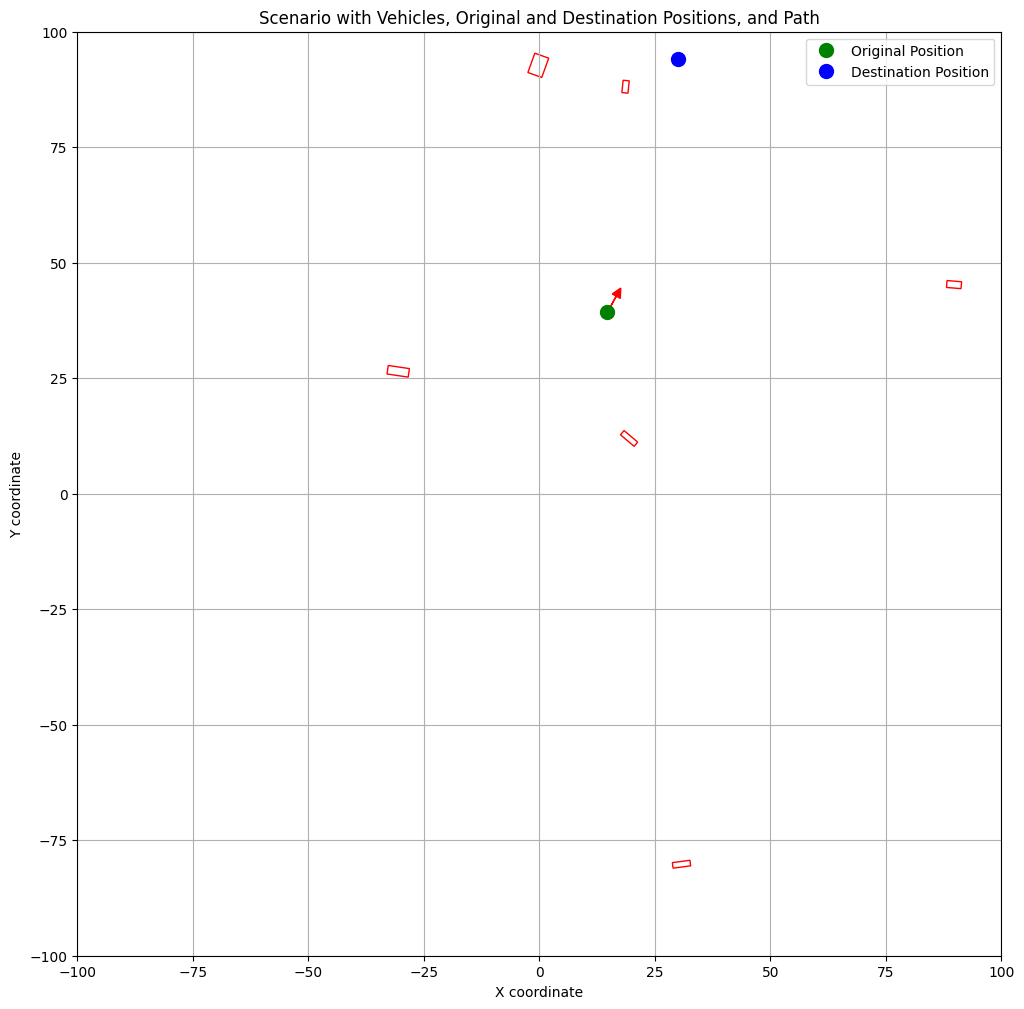

In [ ]:
scenario = Scenario(vehicle_range=(5,7))
scenario.visualise()

In [ ]:
x_range, y_range, vehicles_string, robot_position, robot_orientation, robot_destination = scenario.describe()

In [ ]:
prompt_template = PromptTemplate.from_template(
'The map the scenario is layed out on has a x-axis range of {x_range} \
and a y-axis range of {y_range}. \n Below is a list of vehicles, the \
format of which is: - (center_x, center_y), orientation, (width, height): \
\n {vehicles_string} \n\n As well as this you are given that the current \
co-ordinates are {robot_position} with an orientation of \
{robot_orientation} (where 0 is east) and the destination co-ordinates \
are {robot_destination}. \n\n Given the above map scenario, formulate a \
series of comma separated instructions for the robot to follow to reach \
from it\'s current position to its destination. Only the following \
instructions types are permitted (with n being the distance or \
anti-clockwise rotation):\n - FORWARD [n] \n - TURN [n]'
)

to_markdown(prompt_template.format(x_range=x_range, y_range=y_range,
                               vehicles_string=vehicles_string,
                               robot_position=robot_position,
                               robot_orientation=robot_orientation,
                               robot_destination=robot_destination))

> The map the scenario is layed out on has a x-axis range of (-100, 100) and a y-axis range of (-100, 100). 
>  Below is a list of vehicles, the format of which is: - (center_x, center_y), orientation, (width, height): 
>  - (89.77585413238532, 45.264988333242655), 184.71352746028427, (3.1613074096265175, 1.499111859182432) 
>  - (-0.21144844701123588, 92.72356410894486), 199.87432333180843, (3.1898977118983565, 4.437477909415531) 
>  - (30.78882669089745, -80.1968117774498), 172.4590957149383, (3.845103885368007, 1.209641290631704) 
>  - (18.67404175565912, 88.09710521703832), 185.76570910999172, (1.3237606414615746, 2.6815753979879546) 
>  - (-30.530348601534513, 26.500001246191147), 98.41864589391867, (1.862833279025332, 4.629653348164895) 
>  - (19.4376181935703, 11.966184287029876), 130.28459124893874, (1.19285014256843, 3.8708650218033758) 
>   
> 
>  As well as this you are given that the current co-ordinates are (14.737447485438054, 39.25695961510712) with an orientation of 61.16490670412016 (where 0 is east) and the destination co-ordinates are (30.0346768682694, 94.0694395175772). 
> 
>  Given the above map scenario, formulate a series of comma separated instructions for the robot to follow to reach from it's current position to its destination. Only the following instructions types are permitted (with n being the distance or anti-clockwise rotation):
>  - FORWARD [n] 
>  - TURN [n]

In [ ]:
chain = LLMChain(llm=model, prompt=prompt_template)
response = chain.invoke(input={"x_range":x_range, "y_range":y_range,
                               "vehicles_string":vehicles_string,
                               "robot_position":robot_position,
                               "robot_orientation":robot_orientation,
                               "robot_destination":robot_destination})["text"]
to_markdown(response)

> TURN 30.895889751967154, FORWARD 70.83866761084535, TURN 130.7182415246708, FORWARD 51.91779335396823

In [ ]:
response.split(", ")

['TURN 30.895889751967154',
 'FORWARD 70.83866761084535',
 'TURN 130.7182415246708',
 'FORWARD 51.91779335396823']

INITIAL POSITION


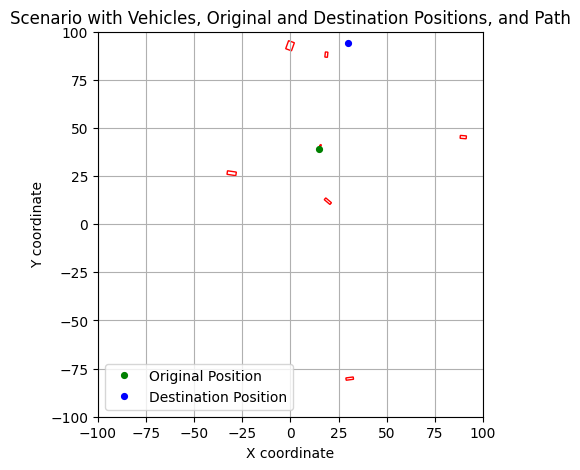


TURN 30.895889751967154


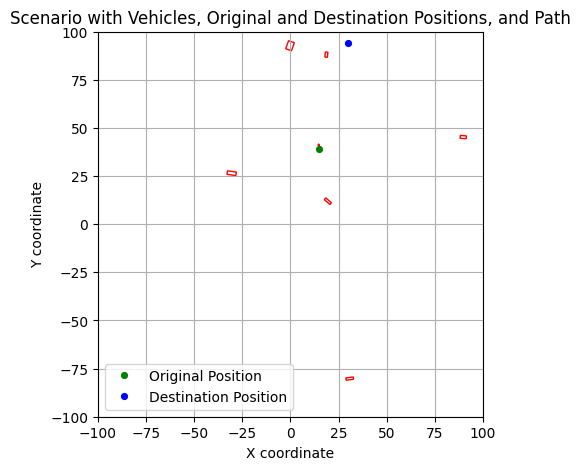


FORWARD 70.83866761084535


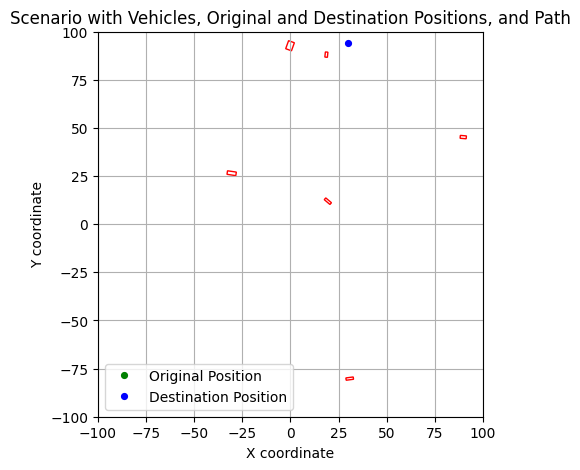


TURN 130.7182415246708


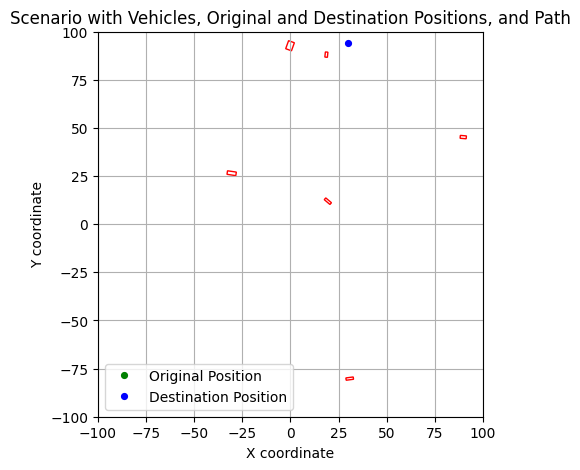


FORWARD 51.91779335396823


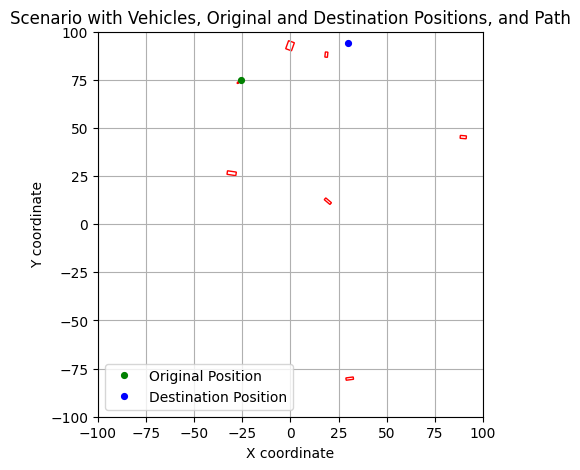


FAILED TO REACH DESTINATION


In [ ]:
scenario.simulate(response.split(", "))

In [ ]:
prompt_template = PromptTemplate.from_template(
'TASK: \n\n \
The map the scenario is layed out on has a x-axis range of {x_range} \
and a y-axis range of {y_range}. \n You will be given a list of vehicles, \
in the format: - (center_x, center_y), orientation, (width, height): You \
will also be given the current co-ordinates and it\'s orientation (where 0 \
is east), along with the destination co-ordinates. \n\n \
Given the map scenario, formulate a series of comma separated instructions \
for the robot to follow to reach from it\'s current position to its \
destination. I have provided an EXAMPLE, complete the ACTUAL INSTRUCTIONS as \
instructed \n\n \
Only the following instructions types are permitted (with n being the \
distance or anti-clockwise rotation):\n - FORWARD [n] \n - TURN [n] \n\n\n \
EXAMPLE: \n\n \
VEHICLES: \n\n - (2, 2), 0, \
(1, 2) \n - (5, 5), 90, (1, 1) \n\n\n \
CURRENT CO-ORDINATES: (1, 1) \n\n \
CURRENT ORIENTATION: 270 \n\n \
DESTINATION CO-ORDINATES: (5, 5) \n\n \
INSTRUCTIONS: TURN 180, FORWARD 3, TURN -90, FORWARD 4, TURN 90, \
FORWARD 1. \n\n \
Below are the results of each instruction from the \
output:\n\n - TURN 180 -> the robot is now facing 90 \n - FORWARD 3 -> the \
robot is now in position (1, 4) \n - TURN -90 -> the robot is now facing 0 \n \
- FORWARD 4 -> the robot is now in position (5, 4) \n - TURN 90 -> the robot \
is now facing 90 \n - FORWARD 1 -> the robot is now in position (5, 5), \
which is the destination. \n\n\n \
Additionally you can see that the robot never collides with any of the \
vehicles during its journey. \n\n \
ACTUAL: \n\n \
VEHICLES: \n {vehicles_string} \n\n\n \
CURRENT CO-ORDINATES: {robot_position} \n\n \
CURRENT ORIENTATION: {robot_orientation} \n\n \
DESTINATION CO-ORDINATES: {robot_destination} \n\n \
INSTRUCTIONS: '
)

to_markdown(prompt_template.format(x_range=x_range, y_range=y_range,
                               vehicles_string=vehicles_string,
                               robot_position=robot_position,
                               robot_orientation=robot_orientation,
                               robot_destination=robot_destination))

> TASK: 
> 
>  The map the scenario is layed out on has a x-axis range of (-100, 100) and a y-axis range of (-100, 100). 
>  You will be given a list of vehicles, in the format: - (center_x, center_y), orientation, (width, height): You will also be given the current co-ordinates and it's orientation (where 0 is east), along with the destination co-ordinates. 
> 
>  Given the map scenario, formulate a series of comma separated instructions for the robot to follow to reach from it's current position to its destination. I have provided an EXAMPLE, complete the ACTUAL INSTRUCTIONS as instructed 
> 
>  Only the following instructions types are permitted (with n being the distance or anti-clockwise rotation):
>  - FORWARD [n] 
>  - TURN [n] 
> 
> 
>  EXAMPLE: 
> 
>  VEHICLES: 
> 
>  - (2, 2), 0, (1, 2) 
>  - (5, 5), 90, (1, 1) 
> 
> 
>  CURRENT CO-ORDINATES: (1, 1) 
> 
>  CURRENT ORIENTATION: 270 
> 
>  DESTINATION CO-ORDINATES: (5, 5) 
> 
>  INSTRUCTIONS: TURN 180, FORWARD 3, TURN -90, FORWARD 4, TURN 90, FORWARD 1. 
> 
>  Below are the results of each instruction from the output:
> 
>  - TURN 180 -> the robot is now facing 90 
>  - FORWARD 3 -> the robot is now in position (1, 4) 
>  - TURN -90 -> the robot is now facing 0 
>  - FORWARD 4 -> the robot is now in position (5, 4) 
>  - TURN 90 -> the robot is now facing 90 
>  - FORWARD 1 -> the robot is now in position (5, 5), which is the destination. 
> 
> 
>  Additionally you can see that the robot never collides with any of the vehicles during its journey. 
> 
>  ACTUAL: 
> 
>  VEHICLES: 
>  - (89.77585413238532, 45.264988333242655), 184.71352746028427, (3.1613074096265175, 1.499111859182432) 
>  - (-0.21144844701123588, 92.72356410894486), 199.87432333180843, (3.1898977118983565, 4.437477909415531) 
>  - (30.78882669089745, -80.1968117774498), 172.4590957149383, (3.845103885368007, 1.209641290631704) 
>  - (18.67404175565912, 88.09710521703832), 185.76570910999172, (1.3237606414615746, 2.6815753979879546) 
>  - (-30.530348601534513, 26.500001246191147), 98.41864589391867, (1.862833279025332, 4.629653348164895) 
>  - (19.4376181935703, 11.966184287029876), 130.28459124893874, (1.19285014256843, 3.8708650218033758) 
>   
> 
> 
>  CURRENT CO-ORDINATES: (14.737447485438054, 39.25695961510712) 
> 
>  CURRENT ORIENTATION: 61.16490670412016 
> 
>  DESTINATION CO-ORDINATES: (30.0346768682694, 94.0694395175772) 
> 
>  INSTRUCTIONS: 

In [ ]:
chain = LLMChain(llm=model, prompt=prompt_template)
response = chain.invoke(input={"x_range":x_range, "y_range":y_range,
                               "vehicles_string":vehicles_string,
                               "robot_position":robot_position,
                               "robot_orientation":robot_orientation,
                               "robot_destination":robot_destination})["text"]
to_markdown(response)

> TURN 21.61045549328483, FORWARD 12.32788027910029, TURN -9.86580518645784, FORWARD 10.508735109708486, TURN 174.50287631928516, FORWARD 45.94147098577817

In [ ]:
response.split(", ")

['TURN 21.61045549328483',
 'FORWARD 12.32788027910029',
 'TURN -9.86580518645784',
 'FORWARD 10.508735109708486',
 'TURN 174.50287631928516',
 'FORWARD 45.94147098577817']

INITIAL POSITION


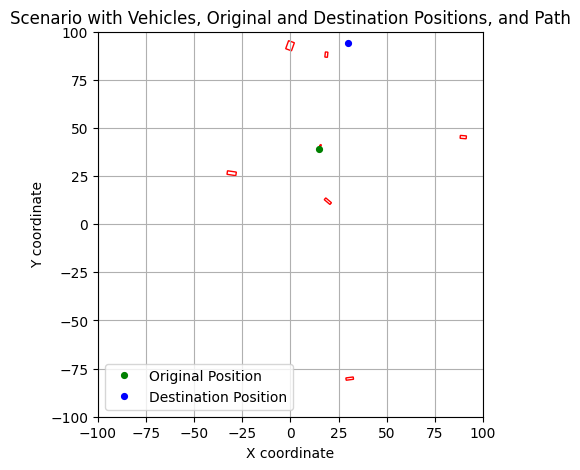


TURN 21.61045549328483


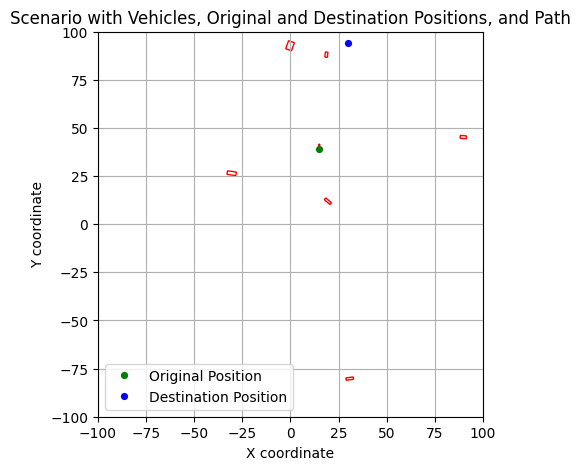


FORWARD 12.32788027910029


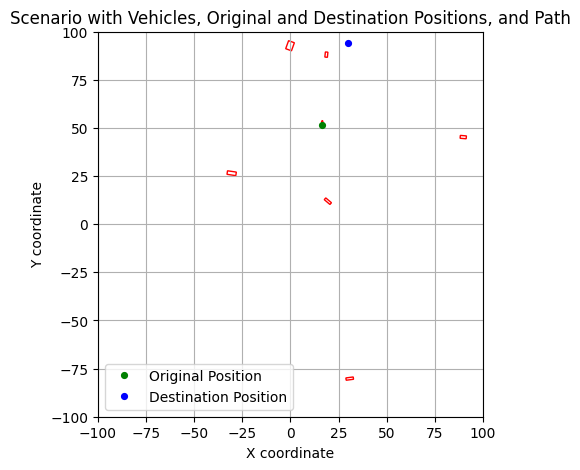


TURN -9.86580518645784


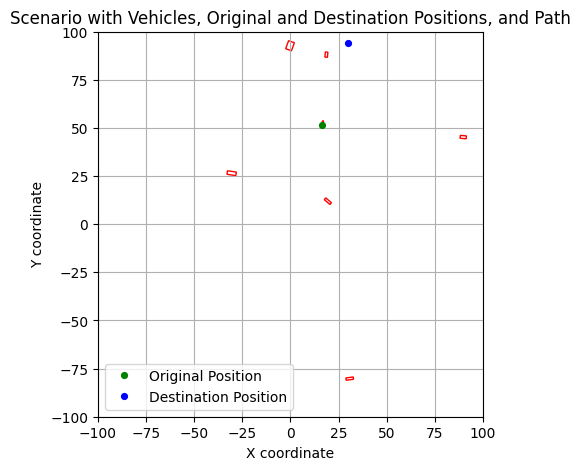


FORWARD 10.508735109708486


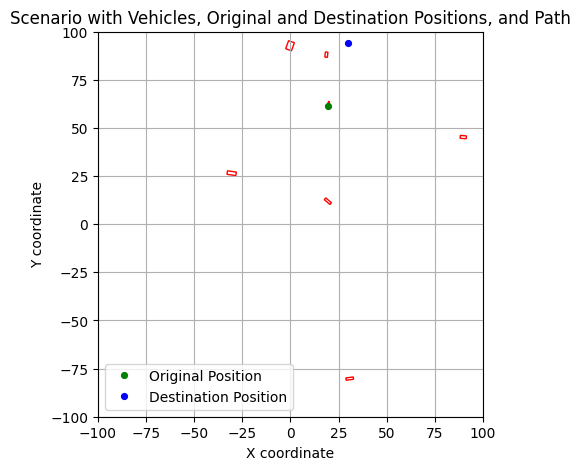


TURN 174.50287631928516


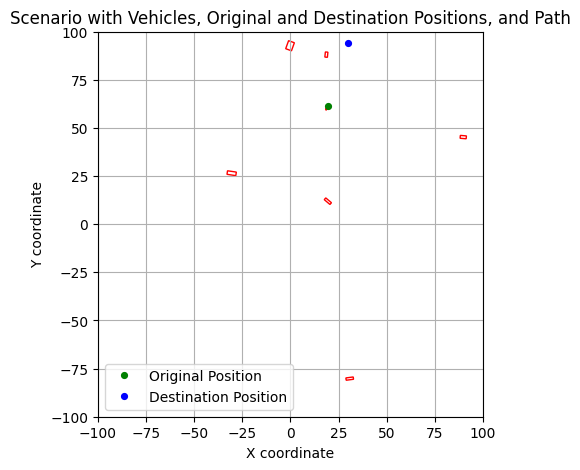


FORWARD 45.94147098577817


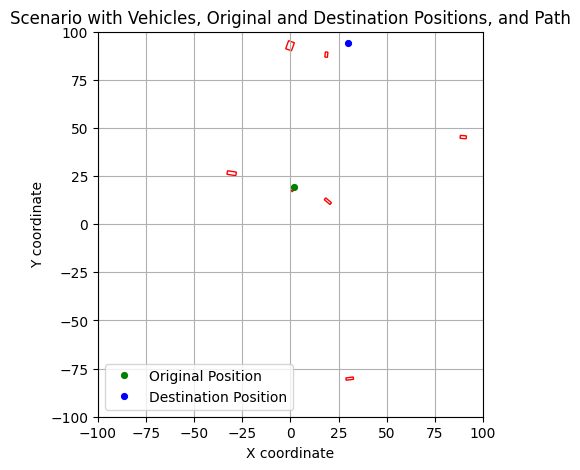


FAILED TO REACH DESTINATION


In [ ]:
scenario.simulate(response.split(", "))

In [ ]:
chain = LLMChain(llm=model, prompt=prompt_template)
response = chain.invoke(input={"x_range":x_range, "y_range":y_range,
                               "vehicles_string":vehicles_string,
                               "robot_position":robot_position,
                               "robot_orientation":robot_orientation,
                               "robot_destination":robot_destination})["text"]
to_markdown(response)

> FORWARD 15.33255979373753, TURN 267.71486789396543, FORWARD 14.148914568518228

In [ ]:
response.split(", ")

['FORWARD 15.33255979373753',
 'TURN 267.71486789396543',
 'FORWARD 14.148914568518228']

INITIAL POSITION


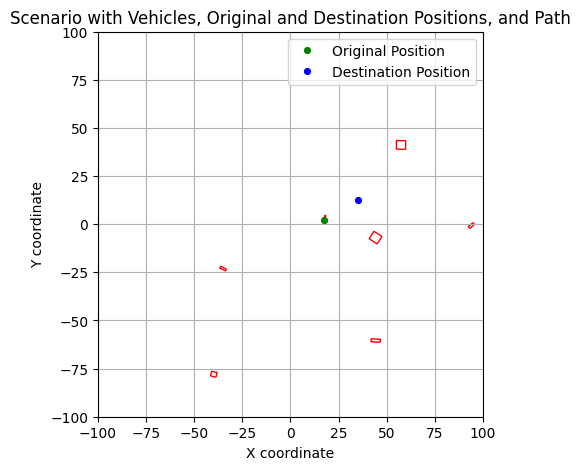


FORWARD 15.33255979373753


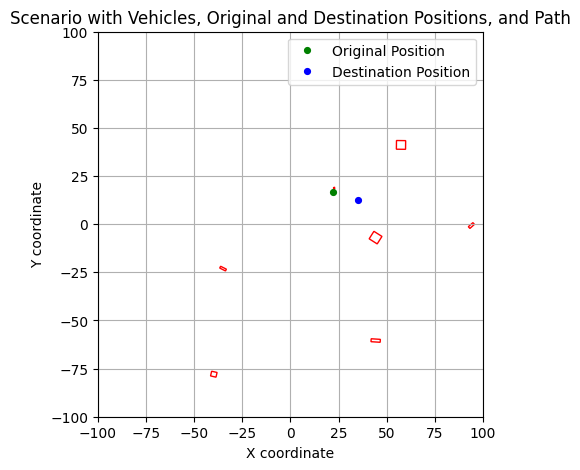


TURN 267.71486789396543


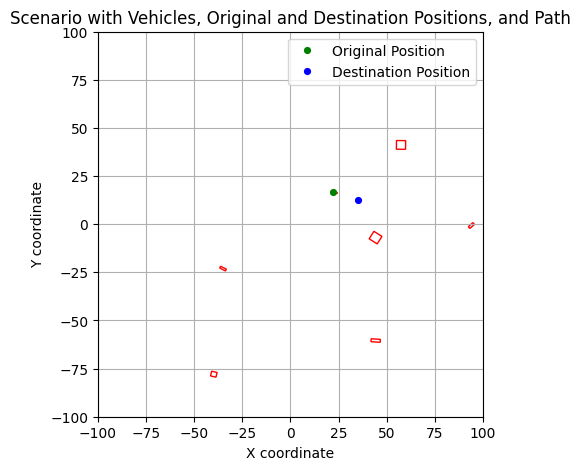


FORWARD 14.148914568518228


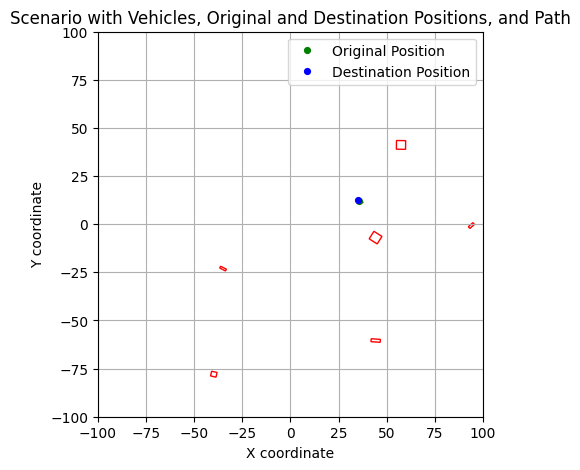


FAILED TO REACH DESTINATION


In [ ]:
scenario.simulate(response.split(", "))

Works sometimes but not always

In [ ]:
prompt_template = PromptTemplate.from_template(
'TASK: \n\n \
The map the scenario is layed out on has a x-axis range of {x_range} \
and a y-axis range of {y_range}. \n You will be given a list of vehicles, \
in the format: - (center_x, center_y), orientation, (width, height): You \
will also be given the current co-ordinates and it\'s orientation (where 0 \
is east), along with the destination co-ordinates. \n\n \
Given the map scenario, formulate a series of comma separated instructions \
for the robot to follow to reach from it\'s current position to its \
destination. I have provided an EXAMPLE, complete the ACTUAL INSTRUCTIONS and \
EXPLANATION as instructed \n\n \
Only the following instructions types are permitted (with n being the \
distance or anti-clockwise rotation):\n - FORWARD [n] \n - TURN [n] \n\n\n \
EXAMPLE: \n\n \
VEHICLES: \n\n - (2, 2), 0, \
(1, 2) \n - (5, 5), 90, (1, 1) \n\n\n \
CURRENT CO-ORDINATES: (1, 1) \n\n \
CURRENT ORIENTATION: 270 \n\n \
DESTINATION CO-ORDINATES: (5, 5) \n\n \
INSTRUCTIONS: TURN 180, FORWARD 3, TURN -90, FORWARD 4, TURN 90, \
FORWARD 1. \n\n \
Below are the results of each instruction from the \
output:\n\n - TURN 180 -> the robot is now facing 90 \n - FORWARD 3 -> the \
robot is now in position (1, 4) \n - TURN -90 -> the robot is now facing 0 \n \
- FORWARD 4 -> the robot is now in position (5, 4) \n - TURN 90 -> the robot \
is now facing 90 \n - FORWARD 1 -> the robot is now in position (5, 5), \
which is the destination. \n\n\n \
ACTUAL: \n\n \
VEHICLES: \n {vehicles_string} \n\n\n \
CURRENT CO-ORDINATES: {robot_position} \n\n \
CURRENT ORIENTATION: {robot_orientation} \n\n \
DESTINATION CO-ORDINATES: {robot_destination} \n\n \
INSTRUCTIONS: \n\n \
EXPLANATION: '
)

to_markdown(prompt_template.format(x_range=x_range, y_range=y_range,
                               vehicles_string=vehicles_string,
                               robot_position=robot_position,
                               robot_orientation=robot_orientation,
                               robot_destination=robot_destination))

> TASK: 
> 
>  The map the scenario is layed out on has a x-axis range of (-100, 100) and a y-axis range of (-100, 100). 
>  You will be given a list of vehicles, in the format: - (center_x, center_y), orientation, (width, height): You will also be given the current co-ordinates and it's orientation (where 0 is east), along with the destination co-ordinates. 
> 
>  Given the map scenario, formulate a series of comma separated instructions for the robot to follow to reach from it's current position to its destination. I have provided an EXAMPLE, complete the ACTUAL INSTRUCTIONS and EXPLANATION as instructed 
> 
>  Only the following instructions types are permitted (with n being the distance or anti-clockwise rotation):
>  - FORWARD [n] 
>  - TURN [n] 
> 
> 
>  EXAMPLE: 
> 
>  VEHICLES: 
> 
>  - (2, 2), 0, (1, 2) 
>  - (5, 5), 90, (1, 1) 
> 
> 
>  CURRENT CO-ORDINATES: (1, 1) 
> 
>  CURRENT ORIENTATION: 270 
> 
>  DESTINATION CO-ORDINATES: (5, 5) 
> 
>  INSTRUCTIONS: TURN 180, FORWARD 3, TURN -90, FORWARD 4, TURN 90, FORWARD 1. 
> 
>  Below are the results of each instruction from the output:
> 
>  - TURN 180 -> the robot is now facing 90 
>  - FORWARD 3 -> the robot is now in position (1, 4) 
>  - TURN -90 -> the robot is now facing 0 
>  - FORWARD 4 -> the robot is now in position (5, 4) 
>  - TURN 90 -> the robot is now facing 90 
>  - FORWARD 1 -> the robot is now in position (5, 5), which is the destination. 
> 
> 
>  ACTUAL: 
> 
>  VEHICLES: 
>  - (89.77585413238532, 45.264988333242655), 184.71352746028427, (3.1613074096265175, 1.499111859182432) 
>  - (-0.21144844701123588, 92.72356410894486), 199.87432333180843, (3.1898977118983565, 4.437477909415531) 
>  - (30.78882669089745, -80.1968117774498), 172.4590957149383, (3.845103885368007, 1.209641290631704) 
>  - (18.67404175565912, 88.09710521703832), 185.76570910999172, (1.3237606414615746, 2.6815753979879546) 
>  - (-30.530348601534513, 26.500001246191147), 98.41864589391867, (1.862833279025332, 4.629653348164895) 
>  - (19.4376181935703, 11.966184287029876), 130.28459124893874, (1.19285014256843, 3.8708650218033758) 
>   
> 
> 
>  CURRENT CO-ORDINATES: (14.737447485438054, 39.25695961510712) 
> 
>  CURRENT ORIENTATION: 61.16490670412016 
> 
>  DESTINATION CO-ORDINATES: (30.0346768682694, 94.0694395175772) 
> 
>  INSTRUCTIONS: 
> 
>  EXPLANATION: 

In [ ]:
chain = LLMChain(llm=model, prompt=prompt_template)
response = chain.invoke(input={"x_range":x_range, "y_range":y_range,
                               "vehicles_string":vehicles_string,
                               "robot_position":robot_position,
                               "robot_orientation":robot_orientation,
                               "robot_destination":robot_destination})["text"]
to_markdown(response)

> INSTRUCTIONS: TURN 123, FORWARD 26, TURN -90, FORWARD 55
> 
> EXPLANATION: 
> 
>  - TURN 123 -> the robot is now facing 184.16490670412016 
>  - FORWARD 26 -> the robot is now in position (14.737447485438054, 65.25695961510712) 
>  - TURN -90 -> the robot is now facing 94.16490670412016 
>  - FORWARD 55 -> the robot is now in position (30.0346768682694, 94.0694395175772), which is the destination.

In [ ]:
t = response.split("EXPLANATION")[0][len("INSTRUCTIONS: "):-2]
t.split(", ")

['TURN 123', 'FORWARD 26', 'TURN -90', 'FORWARD 55']

INITIAL POSITION


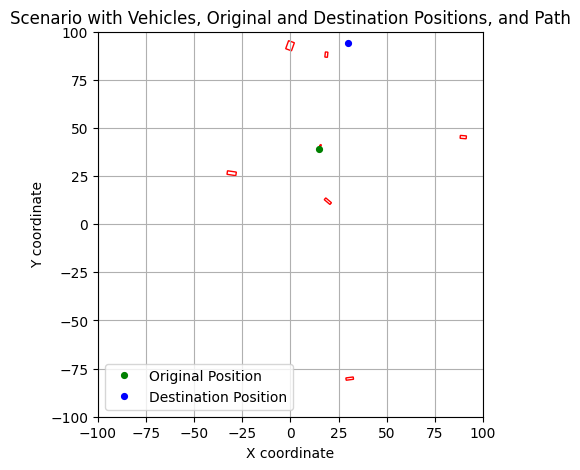


TURN 123


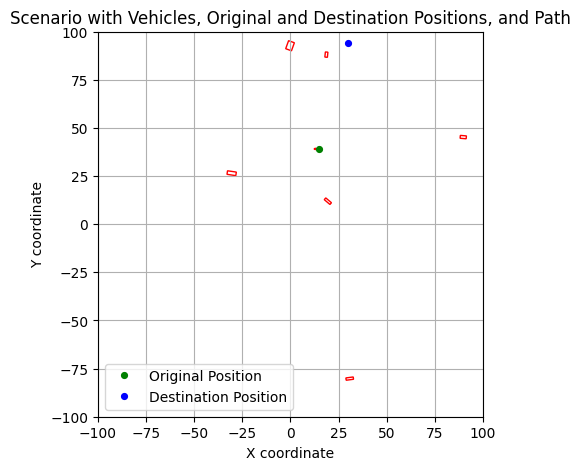


FORWARD 26


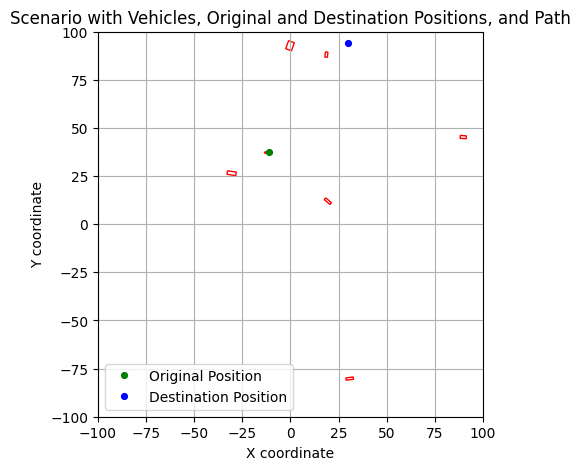


TURN -90


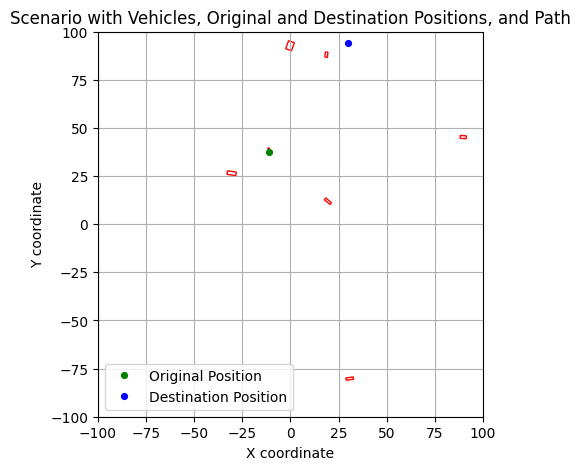


FORWARD 55


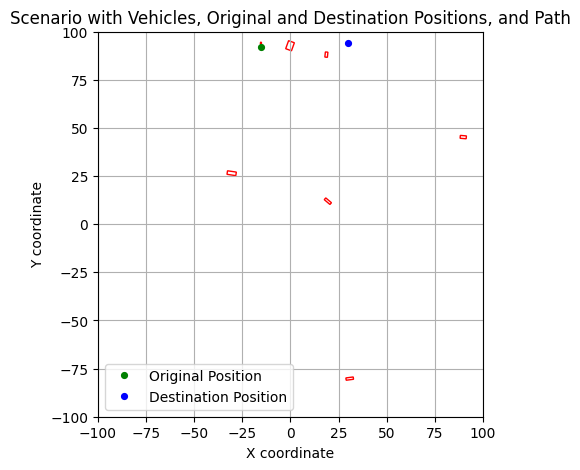


FAILED TO REACH DESTINATION


In [ ]:
scenario.simulate(t.split(", "))

Struggles to follow chain of logic with concrete numbers.

# Agent

In [9]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

llm = ChatGoogleGenerativeAI(model="gemini-pro",
                               google_api_key=GOOGLE_API_KEY,
                               convert_system_message_to_human=True)

@tool
def search(query: str) -> str:
    """Look up things online."""
    return "LangChain"

@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a+b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


In [10]:
tools = [search, multiply, add]

agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
                         verbose=True)

print(agent.agent.llm_chain.prompt)
agent.run("What is the result of 12376*3456 + 2?")

# multi-input issue: https://github.com/langchain-ai/langchain/issues/3700
# Structured tools: https://blog.langchain.dev/structured-tools/

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


input_variables=['agent_scratchpad', 'input'] messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='Respond to the human as helpfully and accurately as possible. You have access to the following tools:\n\nsearch: search(query: str) -> str - Look up things online., args: {{\'query\': {{\'title\': \'Query\', \'type\': \'string\'}}}}\nmultiply: multiply(a: int, b: int) -> int - Multiply two numbers., args: {{\'a\': {{\'title\': \'A\', \'type\': \'integer\'}}, \'b\': {{\'title\': \'B\', \'type\': \'integer\'}}}}\nadd: add(a: int, b: int) -> int - Add two numbers., args: {{\'a\': {{\'title\': \'A\', \'type\': \'integer\'}}, \'b\': {{\'title\': \'B\', \'type\': \'integer\'}}}}\n\nUse a json blob to specify a tool by providing an action key (tool name) and an action_input key (tool input).\n\nValid "action" values: "Final Answer" or search, multiply, add\n\nProvide only ONE action per $JSON_BLOB, as shown:\n\n```\n{{\n  "action": $TOOL_NAME,\n  "action_inpu

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Action:
```
{
  "action": "add",
  "action_input": {
    "a": 42771456,
    "b": 2
  }
}
```
Observation: 42771458
Thought:Action:
```
{
  "action": "Final Answer",
  "action_input": "The result of 12376*3456 + 2 is 42771458."
}
```

> Finished chain.


'The result of 12376*3456 + 2 is 42771458.'

# Prompt Templates

## Prompt Generation

In [ ]:
prompt_template = PromptTemplate.from_template(
    "Tell me a {adjective} joke about {content}."
)
prompt_template.format(adjective="funny", content="chickens")

'Tell me a funny joke about chickens.'

In [ ]:
chat_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful AI bot. Your name is {name}."),
        ("human", "Hello, how are you doing?"),
        ("ai", "I'm doing well, thanks!"),
        ("human", "{user_input}"),
    ]
)

messages = chat_template.format_messages(name="Bob",
                                         user_input="What is your name?")
print(messages)

[SystemMessage(content='You are a helpful AI bot. Your name is Bob.'), HumanMessage(content='Hello, how are you doing?'), AIMessage(content="I'm doing well, thanks!"), HumanMessage(content='What is your name?')]


In [ ]:
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "You are a helpful assistant that re-writes the user's text to "
                "sound more upbeat."
            )
        ),
        HumanMessagePromptTemplate.from_template("{text}"),
    ]
)
messages = chat_template.format_messages(
    text="I don't like eating tasty things")
print(messages)

[SystemMessage(content="You are a helpful assistant that re-writes the user's text to sound more upbeat."), HumanMessage(content="I don't like eating tasty things")]


In [ ]:
prompt_val = prompt_template.invoke({"adjective": "funny", "content": "chickens"})
print(prompt_val.to_string())
prompt_val

Tell me a funny joke about chickens.


StringPromptValue(text='Tell me a funny joke about chickens.')

In [ ]:
prompt_val.to_messages()

[HumanMessage(content='Tell me a funny joke about chickens.')]

In [ ]:
chat_val = chat_template.invoke({"text": "i dont like eating tasty things."})
chat_val.to_messages()

[SystemMessage(content="You are a helpful assistant that re-writes the user's text to sound more upbeat."),
 HumanMessage(content='i dont like eating tasty things.')]

In [ ]:
chat_val.to_string()

"System: You are a helpful assistant that re-writes the user's text to sound more upbeat.\nHuman: i dont like eating tasty things."

In [ ]:
prompt = (
    PromptTemplate.from_template("Tell me a joke about {topic}")
    + ", make it funny"
    + "\n\nand in {language}"
)
prompt

PromptTemplate(input_variables=['language', 'topic'], template='Tell me a joke about {topic}, make it funny\n\nand in {language}')

In [ ]:
prompt.format(topic="sports", language="spanish")

'Tell me a joke about sports, make it funny\n\nand in spanish'

In [ ]:
chain = LLMChain(llm=model, prompt=prompt)
response = chain.invoke(input={"topic":"sports", "language":"spanish"})["text"]
to_markdown(response)

> ¿Qué le dijo una portería a un balón?
> 
> ¡Pásame la pelota!

In [ ]:
prompt = SystemMessage(content="You are a nice pirate")
new_prompt = (
    prompt + HumanMessage(content="hi") + AIMessage(content="what?") + "{input}"
)
new_prompt.format_messages(input="i said hi")

[SystemMessage(content='You are a nice pirate'),
 HumanMessage(content='hi'),
 AIMessage(content='what?'),
 HumanMessage(content='i said hi')]

In [ ]:
chain = LLMChain(llm=model, prompt=new_prompt)
chain.invoke("i said hi")

{'input': 'i said hi',
 'text': 'Hello there! I am a friendly pirate. What can I do for you?'}

## Few-shot Prompting

### By Length

In [ ]:
# Examples of a pretend task of creating antonyms.
examples = [
    {"input": "happy", "output": "sad"},
    {"input": "tall", "output": "short"},
    {"input": "energetic", "output": "lethargic"},
    {"input": "sunny", "output": "gloomy"},
    {"input": "windy", "output": "calm"},
]

example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Input: {input}\nOutput: {output}",
)
example_selector = LengthBasedExampleSelector(
    # The examples it has available to choose from.
    examples=examples,
    # The PromptTemplate being used to format the examples.
    example_prompt=example_prompt,
    # The maximum length that the formatted examples should be.
    # Length is measured by the get_text_length function below.
    max_length=25,
    # The function used to get the length of a string, which is used
    # to determine which examples to include. It is commented out because
    # it is provided as a default value if none is specified.
    # get_text_length: Callable[[str], int] = lambda x: len(re.split("\n| ", x))
)
dynamic_prompt = FewShotPromptTemplate(
    # We provide an ExampleSelector instead of examples.
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Give the antonym of every input",
    suffix="Input: {adjective}\nOutput:",
    input_variables=["adjective"],
)

# An example with small input, so it selects all examples.
print(dynamic_prompt.format(adjective="big"))

Give the antonym of every input

Input: happy
Output: sad

Input: tall
Output: short

Input: energetic
Output: lethargic

Input: sunny
Output: gloomy

Input: windy
Output: calm

Input: big
Output:


In [ ]:
# An example with long input, so it selects only one example.
long_string = "big and huge and massive and large and gigantic and tall and much much much much much bigger than everything else"
print(dynamic_prompt.format(adjective=long_string))

Give the antonym of every input

Input: happy
Output: sad

Input: big and huge and massive and large and gigantic and tall and much much much much much bigger than everything else
Output:


In [ ]:
# You can add an example to an example selector as well.
new_example = {"input": "big", "output": "small"}
dynamic_prompt.example_selector.add_example(new_example)
print(dynamic_prompt.format(adjective="enthusiastic"))

Give the antonym of every input

Input: happy
Output: sad

Input: tall
Output: short

Input: energetic
Output: lethargic

Input: sunny
Output: gloomy

Input: windy
Output: calm

Input: big
Output: small

Input: enthusiastic
Output:


### By Similarity (MMR)

In [ ]:
example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Input: {input}\nOutput: {output}",
)

# Examples of a pretend task of creating antonyms.
examples = [
    {"input": "happy", "output": "sad"},
    {"input": "tall", "output": "short"},
    {"input": "energetic", "output": "lethargic"},
    {"input": "sunny", "output": "gloomy"},
    {"input": "windy", "output": "calm"},
]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.7 MB/s eta 0:00:00


In [ ]:
example_selector = MaxMarginalRelevanceExampleSelector.from_examples(
    # The list of examples available to select from.
    examples,
    # The embedding class used to produce embeddings which are used to measure semantic similarity.
    HuggingFaceBgeEmbeddings(),
    # The VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS,
    # The number of examples to produce.
    k=2,
)
mmr_prompt = FewShotPromptTemplate(
    # We provide an ExampleSelector instead of examples.
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Give the antonym of every input",
    suffix="Input: {adjective}\nOutput:",
    input_variables=["adjective"],
)

In [ ]:
# Input is a feeling, so should select the happy/sad example as the first one
print(mmr_prompt.format(adjective="worried"))

Give the antonym of every input

Input: happy
Output: sad

Input: energetic
Output: lethargic

Input: worried
Output:


In [ ]:
# Let's compare this to what we would just get if we went solely off of similarity,
# by using SemanticSimilarityExampleSelector instead of MaxMarginalRelevanceExampleSelector.
example_selector = SemanticSimilarityExampleSelector.from_examples(
    # The list of examples available to select from.
    examples,
    # The embedding class used to produce embeddings which are used to measure semantic similarity.
    HuggingFaceBgeEmbeddings(),
    # The VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS,
    # The number of examples to produce.
    k=2,
)
similar_prompt = FewShotPromptTemplate(
    # We provide an ExampleSelector instead of examples.
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Give the antonym of every input",
    suffix="Input: {adjective}\nOutput:",
    input_variables=["adjective"],
)
print(similar_prompt.format(adjective="worried"))

Give the antonym of every input

Input: happy
Output: sad

Input: energetic
Output: lethargic

Input: worried
Output:


(this should be different since MMR also tries to have diversity)

### N-gram overlap

In [ ]:
example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Input: {input}\nOutput: {output}",
)

# Examples of a fictional translation task.
examples = [
    {"input": "See Spot run.", "output": "Ver correr a Spot."},
    {"input": "My dog barks.", "output": "Mi perro ladra."},
    {"input": "Spot can run.", "output": "Spot puede correr."},
]

In [ ]:
example_selector = NGramOverlapExampleSelector(
    # The examples it has available to choose from.
    examples=examples,
    # The PromptTemplate being used to format the examples.
    example_prompt=example_prompt,
    # The threshold, at which selector stops.
    # It is set to -1.0 by default.
    threshold=-1.0,
    # For negative threshold:
    # Selector sorts examples by ngram overlap score, and excludes none.
    # For threshold greater than 1.0:
    # Selector excludes all examples, and returns an empty list.
    # For threshold equal to 0.0:
    # Selector sorts examples by ngram overlap score,
    # and excludes those with no ngram overlap with input.
)
dynamic_prompt = FewShotPromptTemplate(
    # We provide an ExampleSelector instead of examples.
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Give the Spanish translation of every input",
    suffix="Input: {sentence}\nOutput:",
    input_variables=["sentence"],
)

In [ ]:
# An example input with large ngram overlap with "Spot can run."
# and no overlap with "My dog barks."
print(dynamic_prompt.format(sentence="Spot can run fast."))

Give the Spanish translation of every input

Input: Spot can run.
Output: Spot puede correr.

Input: See Spot run.
Output: Ver correr a Spot.

Input: My dog barks.
Output: Mi perro ladra.

Input: Spot can run fast.
Output:


In [ ]:
# You can add examples to NGramOverlapExampleSelector as well.
new_example = {"input": "Spot plays fetch.", "output": "Spot juega a buscar."}

example_selector.add_example(new_example)
print(dynamic_prompt.format(sentence="Spot can run fast."))

Give the Spanish translation of every input

Input: Spot can run.
Output: Spot puede correr.

Input: See Spot run.
Output: Ver correr a Spot.

Input: Spot plays fetch.
Output: Spot juega a buscar.

Input: My dog barks.
Output: Mi perro ladra.

Input: Spot can run fast.
Output:


In [ ]:
# Setting small nonzero threshold
example_selector.threshold = 0.09
print(dynamic_prompt.format(sentence="Spot can play fetch."))

Give the Spanish translation of every input

Input: Spot can run.
Output: Spot puede correr.

Input: Spot plays fetch.
Output: Spot juega a buscar.

Input: Spot can play fetch.
Output:


### Custom Example Selector

In [ ]:
examples = [
    {"input": "hi", "output": "ciao"},
    {"input": "bye", "output": "arrivaderci"},
    {"input": "soccer", "output": "calcio"},
]

In [ ]:
class CustomExampleSelector(BaseExampleSelector):
    def __init__(self, examples):
        self.examples = examples

    def add_example(self, example):
        self.examples.append(example)

    def select_examples(self, input_variables):
        # This assumes knowledge that part of the input will be a 'text' key
        new_word = input_variables["input"]
        new_word_length = len(new_word)

        # Initialize variables to store the best match and its length difference
        best_match = None
        smallest_diff = float("inf")

        # Iterate through each example
        for example in self.examples:
            # Calculate the length difference with the first word of the example
            current_diff = abs(len(example["input"]) - new_word_length)

            # Update the best match if the current one is closer in length
            if current_diff < smallest_diff:
                smallest_diff = current_diff
                best_match = example

        return [best_match]

In [ ]:
example_selector = CustomExampleSelector(examples)

In [ ]:
example_selector.select_examples({"input": "okay"})

[{'input': 'bye', 'output': 'arrivaderci'}]

In [ ]:
example_selector.add_example({"input": "hand", "output": "mano"})

In [ ]:
example_selector.select_examples({"input": "okay"})

[{'input': 'hand', 'output': 'mano'}]

In [ ]:
example_prompt = PromptTemplate.from_template("Input: {input} -> Output: {output}")

prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    suffix="Input: {input} -> Output:",
    prefix="Translate the following words from English to Italain:",
    input_variables=["input"],
)

print(prompt.format(input="word"))

Translate the following words from English to Italain:

Input: hand -> Output: mano

Input: word -> Output:


In [ ]:
#   def __get_rectangle_corners(center_x, center_y, yaw, width, height):
#   """
#   Calculates the co-ordinates of the corners of a rectangle given its center point, yaw, width, and height.

#   Args:
#     center_x: The x-coordinate of the center point.
#     center_y: The y-coordinate of the center point.
#     yaw: The yaw angle of the rectangle in radians.
#     width: The width of the rectangle.
#     height: The height of the rectangle.

#   Returns:
#     A list of four tuples, each representing the coordinates of a corner.
#   """

#   half_width = width / 2
#   half_height = height / 2

#   # Calculate the corners in the rectangle's local coordinate frame.
#   local_corners = [
#       (-half_width, -half_height),
#       (half_width, -half_height),
#       (half_width, half_height),
#       (-half_width, half_height),
#   ]

#   # Rotate the corners by the yaw angle.
#   rotated_corners = []
#   for corner in local_corners:
#     rotated_corner = (
#         center_x + math.cos(yaw) * corner[0] - math.sin(yaw) * corner[1],
#         center_y + math.sin(yaw) * corner[0] + math.cos(yaw) * corner[1],
#     )
#     rotated_corners.append(rotated_corner)

#   return rotated_corners

# def no_overlap(rect1, rect2, gap):
#   """
#   Checks if there is no overlap between two rectangles, with a bit of gap.

#   Args:
#       rect1: A tuple containing the coordinates of the bottom-left and top-right corners of the first rectangle: (x1, y1, x2, y2).
#       rect2: A tuple containing the coordinates of the bottom-left and top-right corners of the second rectangle: (x1, y1, x2, y2).
#       gap: The minimum gap between the rectangles.

#   Returns:
#       True if there is no overlap between the rectangles, with a bit of gap, False otherwise.
#   """

#   # Check if the rectangles are on the same horizontal or vertical line.
#   if (rect1[0] == rect2[0] or rect1[2] == rect2[2]) and (rect1[1] == rect2[1] or rect1[3] == rect2[3]):
#     return False

#   # Check if the rectangles overlap horizontally.
#   if not (rect1[2] + gap < rect2[0] or rect2[2] + gap < rect1[0]):
#     return False

#   # Check if the rectangles overlap vertically.
#   if not (rect1[3] + gap < rect2[1] or rect2[3] + gap < rect1[1]):
#     return False

#   # If all the checks are passed, then there is no overlap between the rectangles, with a bit of gap.
#   return True
